The purpose of this notebook is to determine the features that influence whether a car will be sold. A classifier is trained using data of cars with sold status vs cars still available. Machine learning sometimes can give insights human cannot explain.

<img src="assets/soldfeatures.png" width="600">

From the features ranked, truck (type of vehicle) seems to be an important feature.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from preprocess_sold import PreprocessedDataFrame
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
def preprocess_sold(df):
    extra_cols = ['price', 'posted', 'last_updated', 'status']
    df = df.drop(extra_cols, axis=1)
    df = df.replace('n.a.', np.nan).replace('n.a', np.nan)
    df['reg_date'] = pd.to_datetime(df.reg_date, format='%d-%b-%Y')
    df['status'] = 1
    return df

def preprocess_unsold(df):
    df = df.drop(['eco_category', 'indicative_price', 'price'], axis=1)
    df['reg_date'] = pd.to_datetime(df.reg_date)
    df['status'] = 0
    return df

In [3]:
FOLDER = ''

sold_df = pd.read_csv(FOLDER + 'dataset_with_extra_attributes.csv')
sold_df = preprocess_sold(sold_df)
print(sold_df.shape)

unsold_df = pd.read_csv(FOLDER + 'train.csv')
unsold_df = preprocess_unsold(unsold_df)
print(unsold_df.shape)

df = sold_df.append(unsold_df.sample(sold_df.shape[0], random_state=42), ignore_index=True)
print(df.shape)
df.head(2)

(5839, 28)
(16784, 28)
(11678, 28)


,mileage,road_tax,dereg_value,coe,engine_cap,curb_weight,manufactured,transmission,omv,arf,power,no_of_owners,depreciation,reg_date,type_of_vehicle,features,accessories,description,category,title,listing_id,make,model,original_reg_date,fuel_type,opc_scheme,lifespan,status
0,NaN,1446,NaN,NaN,2198,1490,2011.0,auto,25473,25473.0,136.0,1,NaN,2011-10-24,luxury sedan,"2.2 litre twinspark engine, selespeed gearbox....","standard factory options, electric seats, stee...",1 owner only! rare alfa romeo for sale. no sti...,"coe car, premium ad car",Alfa Romeo 159 2.2A JTS Selespeed (New 10-yr COE),1027303,alfa romeo,159,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,7174,1962,NaN,1974.0,auto,NaN,NaN,NaN,more than 6,NaN,1974-07-18,sports car,NaN,3494,"fully restored, very good condition new paint ...","coe car, rare & exotic, low mileage car, vinta...",Alfa Romeo Spider 2000 (COE till 02/2022),925918,alfa romeo,2000,NaN,NaN,NaN,NaN,1


### Split data

In [4]:
y = df.pop('status')
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
print('Train:', X_train.shape)
print('Test:', X_test.shape)

X_train.head(2)

Train: (9342, 27)
Test: (2336, 27)


,mileage,road_tax,dereg_value,coe,engine_cap,curb_weight,manufactured,transmission,omv,arf,power,no_of_owners,depreciation,reg_date,type_of_vehicle,features,accessories,description,category,title,listing_id,make,model,original_reg_date,fuel_type,opc_scheme,lifespan
1233,NaN,4728,NaN,94890,4497,1640,2012.0,auto,373738,373738.0,419.0,3,NaN,2013-05-10,sports car,"ferrari's mighty v8 engine producing 570hp, ch...","carbon fiber driver led zone, carbon fiber rac...",stunning rosso corsa paintwork matched with bl...,"parf car, rare & exotic, premium ad car, low m...",Ferrari 458 Italia Spider,1027985,ferrari,458,NaN,NaN,NaN,NaN
185,NaN,1194,NaN,65501,1984,1830,2014.0,auto,44911,54876.0,165.0,2,NaN,2015-09-29,suv,powerful and reliable 2.0l turbocharged engine...,keyless entry. keyless start stop. paddle shif...,agent unit! 2 owner low mileage unit! pristine...,NaN,Audi Q5 2.0A TFSI Quattro,1013579,audi,q5,NaN,NaN,NaN,NaN


## Preprocessing

**NOTE**: On windows, you might receive an error `Overflowerror: Python int too large to convert to C long` when you run the cell below with the `dataset_with_extra_attributes.csv`. It could be fixed by chaging the dtype from np.int to np.float64 but it will affect other tasks. Hence, we have decided to not make this change and continue with the other tasks.

### Train data

In [5]:
preprocessed_df = PreprocessedDataFrame(X_train, y_train, target_encoding=True)
X_train_prepared = preprocessed_df.build_dataframe()

Date: ['reg_date', 'manufactured', 'lifespan', 'original_reg_date']
Num: ['arf', 'omv', 'depreciation', 'mileage', 'power', 'engine_cap', 'coe', 'no_of_owners', 'dereg_value', 'curb_weight', 'road_tax']
OneHot Cat: ['title', 'make', 'model']
Label Cat: ['category', 'features', 'transmission', 'description', 'opc_scheme', 'listing_id', 'accessories', 'fuel_type']
26

transformed_attribs 40 ['years_since_reg_date', 'years_since_manufactured', 'make', 'model', 'transmission', 'fuel_type', 'cat_parf', 'cat_premium_ad', 'cat_low_mileage', 'cat_imported_used', 'cat_coe', 'cat_almost_new', 'cat_rare_&_exotic', 'cat_hybrid', 'cat_direct_owner_sale', 'cat_sgcarmart_warranty', 'cat_vintage', 'cat_sta_evaluated', 'cat_opc', 'cat_consignment', 'cat_electric', 'arf', 'omv', 'power', 'engine_cap', 'coe', 'no_of_owners', 'curb_weight', 'road_tax', 'tov_bus/mini bus', 'tov_hatchback', 'tov_luxury sedan', 'tov_mid-sized sedan', 'tov_mpv', 'tov_others', 'tov_sports car', 'tov_stationwagon', 'tov_suv', '

In [6]:
model_target_encoder = TargetEncoder()
X_train_prepared.loc[:, 'model'] = model_target_encoder.fit_transform(X_train_prepared.pop('model'), y=y_train)

make_target_encoder = TargetEncoder()
X_train_prepared.loc[:, 'make'] = make_target_encoder.fit_transform(X_train_prepared.pop('make'), y=y_train)

imputer = SimpleImputer()
X_train_prepared = imputer.fit_transform(X_train_prepared)

In [7]:
preprocessed_df.get_transformed_attribs()

['years_since_reg_date',
 'years_since_manufactured',
 'make',
 'model',
 'transmission',
 'fuel_type',
 'cat_parf',
 'cat_premium_ad',
 'cat_low_mileage',
 'cat_imported_used',
 'cat_coe',
 'cat_almost_new',
 'cat_rare_&_exotic',
 'cat_hybrid',
 'cat_direct_owner_sale',
 'cat_sgcarmart_warranty',
 'cat_vintage',
 'cat_sta_evaluated',
 'cat_opc',
 'cat_consignment',
 'cat_electric',
 'arf',
 'omv',
 'power',
 'engine_cap',
 'coe',
 'no_of_owners',
 'curb_weight',
 'road_tax',
 'tov_bus/mini bus',
 'tov_hatchback',
 'tov_luxury sedan',
 'tov_mid-sized sedan',
 'tov_mpv',
 'tov_others',
 'tov_sports car',
 'tov_stationwagon',
 'tov_suv',
 'tov_truck',
 'tov_van']

### Test data

In [8]:
def preprocess_test(X_test):
    X_test_prepared = preprocessed_df.transform_dataframe(X_test)
    X_test_prepared.loc[:, 'model'] = model_target_encoder.transform(X_test_prepared.pop('model'))
    X_test_prepared.loc[:, 'make'] = make_target_encoder.transform(X_test_prepared.pop('make'))
    X_test_prepared = imputer.transform(X_test_prepared)
    return X_test_prepared

In [9]:
X_test_prepared = preprocess_test(X_test)

Input shape: (2336, 27)
Transformed shape: (2336, 40)


## Model

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

lin_clf 0.5560903527977608 0.007527417739085417
tree_clf 0.603297002943323 0.008862553383526112
rf_clf 0.6560717923336118 0.009685819794518514
svm_clf 0.6087562426746316 0.0028985464233145276
[15:46:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if yo

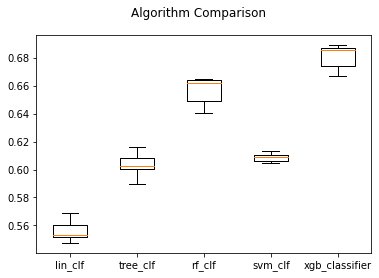

In [11]:
models = []
models.append(('lin_clf', SGDClassifier()))
models.append(('tree_clf', DecisionTreeClassifier()))
models.append(('rf_clf', RandomForestClassifier()))
models.append(('svm_clf', SVC()))
models.append(('xgb_classifier', XGBClassifier()))

results = []
names = []
for name, model in models:
    reg = model.fit(X_train_prepared, y_train)
    scores = cross_val_score(reg, X_train_prepared, y_train, cv=5, scoring="accuracy")
    results.append(scores)
    names.append(name)
    print(f'{name} \033[1m{scores.mean()}\033[0m {scores.std()}')
    
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Grid search: Random Forest

In [11]:
# NOTE: Even if this cell fails, you can continue running all the other cells.
! rm clf.pkl

In [12]:
model_file = 'clf.pkl'

In [13]:
try:
    grid_search = joblib.load(model_file)
except:
    n_estimators = [100, 200, 400]
    max_depth  = [5, 10]
    max_features = ['auto', 'sqrt', 'log2']
    param_grid = [
        {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features},
      ]

    classifier = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(classifier, param_grid, cv=3,
                               scoring='accuracy',
                               return_train_score=True)
    grid_search.fit(X_train_prepared, y_train)
    joblib.dump(grid_search, model_file)

#### Grid search results

In [13]:
print(grid_search.best_params_, grid_search.cv_results_['mean_test_score'].min())
print(grid_search.best_estimator_)

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 400} 0.6253478912438449
RandomForestClassifier(max_depth=10, n_estimators=400, random_state=42)


In [15]:
cvres = grid_search.cv_results_
result_df = pd.DataFrame(grid_search.cv_results_)
result_df.loc[:, [col for col in result_df if col.startswith('param')] + ['mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head()

,param_max_depth,param_max_features,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score
14,10,sqrt,400,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.676086,0.010075,1
13,10,sqrt,200,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.676086,0.008717,1
11,10,auto,400,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",0.676086,0.010075,1
10,10,auto,200,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",0.676086,0.008717,1
17,10,log2,400,"{'max_depth': 10, 'max_features': 'log2', 'n_e...",0.671805,0.010043,5


#### Feature importance

In [16]:
feature_importances = grid_search.best_estimator_.feature_importances_
print('feature_importances', len(feature_importances))

feature_importances 40


In [17]:
important_features = sorted(zip(feature_importances, preprocessed_df.transformed_attribs), reverse=True)
important_features[:10]

[(0.16385274047796186, 'tov_truck'),
 (0.07522578815745659, 'coe'),
 (0.07340598287626142, 'cat_consignment'),
 (0.07071689290139667, 'arf'),
 (0.06768038606793098, 'omv'),
 (0.06593066964338684, 'tov_van'),
 (0.06148589733299037, 'cat_electric'),
 (0.05491865674249578, 'no_of_owners'),
 (0.046017814327556715, 'power'),
 (0.03662468029654356, 'cat_hybrid')]

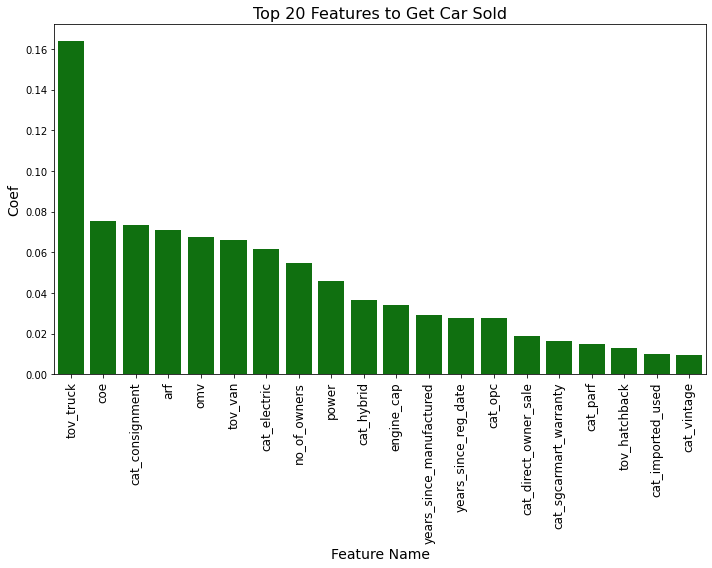

In [18]:
df = pd.DataFrame(important_features, columns=["value", "feature"])
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
title = 'Top 20 Features to Get Car Sold'
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
ax.set_title(title, fontsize=16)
ax.set_ylabel("Coef", fontsize=14)
ax.set_xlabel("Feature Name", fontsize=14)
plt.savefig('assets/soldfeatures', dpi=300, facecolor='white')
plt.tight_layout()
plt.show()

### Grid Search: XGB Classifier

In [19]:
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [20]:
def objective(trial: Trial,X,y) -> float:
    
    joblib.dump(study, 'study.pkl')

    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 0, 2000),
                'max_depth':trial.suggest_int('max_depth', 2, 250),
                'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
                'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 10),
                'gamma':trial.suggest_int('gamma', 0, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1,
                'random_state': 42
            }
    
    model = XGBClassifier(**param)
    
    return cross_val_score(model, X, y, cv=3).mean()

In [20]:
# NOTE: This cell takes about ~8 minutes to run
study = optuna.create_study(direction='maximize',sampler=TPESampler(seed=42))
study.optimize(lambda trial : objective(trial,X_train_prepared,y_train),n_trials= 20)

[I 2021-11-11 15:47:41,254] A new study created in memory with name: no-name-12149279-020d-4d26-b66d-dabf03e94d7f


[15:47:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:48:12,234] Trial 0 finished with value: 0.6936416184971099 and parameters: {'n_estimators': 749, 'max_depth': 238, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 1, 'gamma': 0, 'learning_rate': 0.00653336961902664, 'colsample_bytree': 0.88}. Best is trial 0 with value: 0.6936416184971099.


[15:48:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:48:38,307] Trial 1 finished with value: 0.6954613573110683 and parameters: {'n_estimators': 1202, 'max_depth': 178, 'reg_alpha': 0, 'reg_lambda': 5, 'min_child_weight': 9, 'gamma': 1, 'learning_rate': 0.011551009439226469, 'colsample_bytree': 0.26}. Best is trial 1 with value: 0.6954613573110683.


[15:48:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:48:54,153] Trial 2 finished with value: 0.6910725754656392 and parameters: {'n_estimators': 608, 'max_depth': 132, 'reg_alpha': 2, 'reg_lambda': 1, 'min_child_weight': 6, 'gamma': 0, 'learning_rate': 0.01919814649902085, 'colsample_bytree': 0.43000000000000005}. Best is trial 1 with value: 0.6954613573110683.


[15:48:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:49:11,192] Trial 3 finished with value: 0.6701991008349389 and parameters: {'n_estimators': 912, 'max_depth': 197, 'reg_alpha': 1, 'reg_lambda': 3, 'min_child_weight': 6, 'gamma': 0, 'learning_rate': 0.08204643365323959, 'colsample_bytree': 0.25}. Best is trial 1 with value: 0.6954613573110683.


[15:49:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:49:14,413] Trial 4 finished with value: 0.6922500535217299 and parameters: {'n_estimators': 130, 'max_depth': 238, 'reg_alpha': 5, 'reg_lambda': 4, 'min_child_weight': 3, 'gamma': 0, 'learning_rate': 0.11679817513130797, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.6954613573110683.


[15:49:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:49:26,112] Trial 5 finished with value: 0.7015628345108115 and parameters: {'n_estimators': 244, 'max_depth': 125, 'reg_alpha': 0, 'reg_lambda': 5, 'min_child_weight': 2, 'gamma': 3, 'learning_rate': 0.02100836027186265, 'colsample_bytree': 0.5700000000000001}. Best is trial 5 with value: 0.7015628345108115.


[15:49:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:49:58,125] Trial 6 finished with value: 0.6967458788268037 and parameters: {'n_estimators': 1093, 'max_depth': 48, 'reg_alpha': 5, 'reg_lambda': 4, 'min_child_weight': 10, 'gamma': 5, 'learning_rate': 0.0784819819433057, 'colsample_bytree': 0.93}. Best is trial 5 with value: 0.7015628345108115.


[15:49:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:50:05,346] Trial 7 finished with value: 0.6661314493684437 and parameters: {'n_estimators': 177, 'max_depth': 50, 'reg_alpha': 0, 'reg_lambda': 1, 'min_child_weight': 4, 'gamma': 1, 'learning_rate': 0.22721919801680068, 'colsample_bytree': 0.42000000000000004}. Best is trial 5 with value: 0.7015628345108115.


[15:50:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:50:48,407] Trial 8 finished with value: 0.6972810961250268 and parameters: {'n_estimators': 562, 'max_depth': 137, 'reg_alpha': 0, 'reg_lambda': 4, 'min_child_weight': 0, 'gamma': 5, 'learning_rate': 0.17516992455793434, 'colsample_bytree': 0.28}. Best is trial 5 with value: 0.7015628345108115.
[I 2021-11-11 15:50:48,623] Trial 9 finished with value: 0.633162063797902 and parameters: {'n_estimators': 11, 'max_depth': 205, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 8, 'gamma': 0, 'learning_rate': 0.02605562297894132, 'colsample_bytree': 0.2}. Best is trial 5 with value: 0.7015628345108115.


[15:50:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[I 2021-11-11 15:50:58,702] Trial 10 finished with value: 0.7029543994861914 and parameters: {'n_estimators': 1891, 'max_depth': 3, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 2, 'gamma': 3, 'learning_rate': 0.4154430483061038, 'colsample_bytree': 0.71}. Best is trial 10 with value: 0.7029543994861914.


[15:50:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:51:10,566] Trial 11 finished with value: 0.6976022265039606 and parameters: {'n_estimators': 1894, 'max_depth': 3, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 2, 'gamma': 3, 'learning_rate': 0.4120795711510894, 'colsample_bytree': 0.7}. Best is trial 10 with value: 0.7029543994861914.


[15:51:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:52:31,056] Trial 12 finished with value: 0.6999571826161421 and parameters: {'n_estimators': 1982, 'max_depth': 81, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 3, 'learning_rate': 0.03657465951689264, 'colsample_bytree': 0.69}. Best is trial 10 with value: 0.7029543994861914.


[15:52:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:53:10,688] Trial 13 finished with value: 0.6783344037679298 and parameters: {'n_estimators': 1496, 'max_depth': 10, 'reg_alpha': 1, 'reg_lambda': 0, 'min_child_weight': 0, 'gamma': 4, 'learning_rate': 0.4985341137518226, 'colsample_bytree': 0.6799999999999999}. Best is trial 10 with value: 0.7029543994861914.


[15:53:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:54:21,020] Trial 14 finished with value: 0.6935345750374653 and parameters: {'n_estimators': 1600, 'max_depth': 89, 'reg_alpha': 1, 'reg_lambda': 5, 'min_child_weight': 5, 'gamma': 2, 'learning_rate': 0.013944107760162226, 'colsample_bytree': 0.8}. Best is trial 10 with value: 0.7029543994861914.


[15:54:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:54:36,098] Trial 15 finished with value: 0.7029543994861914 and parameters: {'n_estimators': 384, 'max_depth': 101, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 3, 'gamma': 4, 'learning_rate': 0.03872575787320608, 'colsample_bytree': 0.59}. Best is trial 10 with value: 0.7029543994861914.


[15:54:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:55:20,909] Trial 16 finished with value: 0.6981374438021838 and parameters: {'n_estimators': 1325, 'max_depth': 42, 'reg_alpha': 3, 'reg_lambda': 1, 'min_child_weight': 4, 'gamma': 4, 'learning_rate': 0.21991132058595894, 'colsample_bytree': 0.59}. Best is trial 10 with value: 0.7029543994861914.


[15:55:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:55:36,965] Trial 17 finished with value: 0.6996360522372083 and parameters: {'n_estimators': 415, 'max_depth': 104, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 4, 'gamma': 4, 'learning_rate': 0.048913239758321424, 'colsample_bytree': 0.76}. Best is trial 10 with value: 0.7029543994861914.


[15:55:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:56:56,714] Trial 18 finished with value: 0.697495183044316 and parameters: {'n_estimators': 1700, 'max_depth': 162, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 7, 'gamma': 4, 'learning_rate': 0.0643935599712504, 'colsample_bytree': 1.0}. Best is trial 10 with value: 0.7029543994861914.


[15:56:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-11-11 15:57:23,254] Trial 19 finished with value: 0.7013487475915222 and parameters: {'n_estimators': 853, 'max_depth': 28, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 3, 'gamma': 2, 'learning_rate': 0.0056952177355786395, 'colsample_bytree': 0.47}. Best is trial 10 with value: 0.7029543994861914.


In [42]:
study.best_trial.params

{'n_estimators': 1891,
 'max_depth': 3,
 'reg_alpha': 2,
 'reg_lambda': 0,
 'min_child_weight': 2,
 'gamma': 3,
 'learning_rate': 0.4154430483061038,
 'colsample_bytree': 0.71}

In [21]:
best_xgb_model = XGBClassifier(**{'n_estimators': 1891,
 'max_depth': 3,
 'reg_alpha': 2,
 'reg_lambda': 0,
 'min_child_weight': 2,
 'gamma': 3,
 'learning_rate': 0.4154430483061038,
 'colsample_bytree': 0.71,
 'random_state': 42
})

In [22]:
best_xgb_model.fit(X_train_prepared, y_train)

[14:13:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.71,
              enable_categorical=False, gamma=3, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.4154430483061038, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=1891, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=2, reg_lambda=0,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

## Test

### XGBoost

In [23]:
from sklearn.metrics import plot_confusion_matrix, mean_squared_error

In [24]:
final_predictions = best_xgb_model.predict(X_test_prepared)

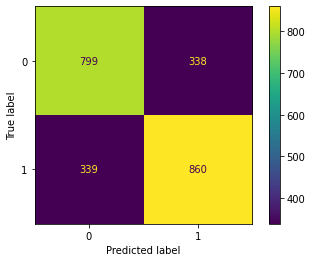

In [47]:
plot_confusion_matrix(best_xgb_model, X_test_prepared, y_test)

In [48]:
print("RMSE: ", mean_squared_error(y_test, final_predictions))

RMSE:  0.2898116438356164


### Random Forest

In [49]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test_prepared)

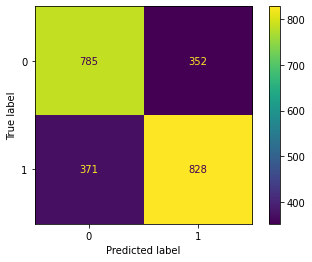

In [50]:
plot_confusion_matrix(final_model, X_test_prepared, y_test)

In [51]:
print("RMSE: ", mean_squared_error(y_test, final_predictions))

RMSE:  0.3095034246575342


Since the XGBoost Model has a better, performance we will explore this model and try to explain it's output using SHAP values.

## Model Explanation

Here, we will try to explore the features that are most important to the XGBoost model, along with how changes in different features affect the overall output.

**NOTE**: You may occasionally see a slightly different SHAP value plot, but the overall order of features should be more or less the same for a *given record*.

In [26]:
import shap

In [27]:
explainer = shap.Explainer(best_xgb_model)

In [28]:
explainer_train_df = pd.DataFrame(X_train_prepared)

In [29]:
explainer_train_df.columns = preprocessed_df.transformed_attribs

In [30]:
shap_values = explainer(explainer_train_df)

### Beeswarm plot

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. 

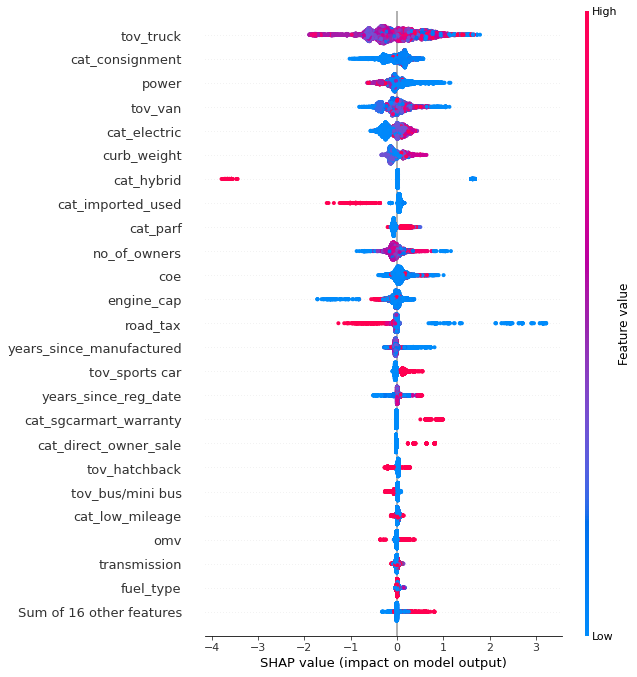

In [62]:
shap.plots.beeswarm(shap_values, max_display=25)

The color represents the feature value (red high, blue low). This reveals for example that having a high `no_of_owners` (% lower status of the population) lowers the chance of the car being sold.

Below, we display the mean absolute value of the SHAP values for each feature to get a standard bar plot.

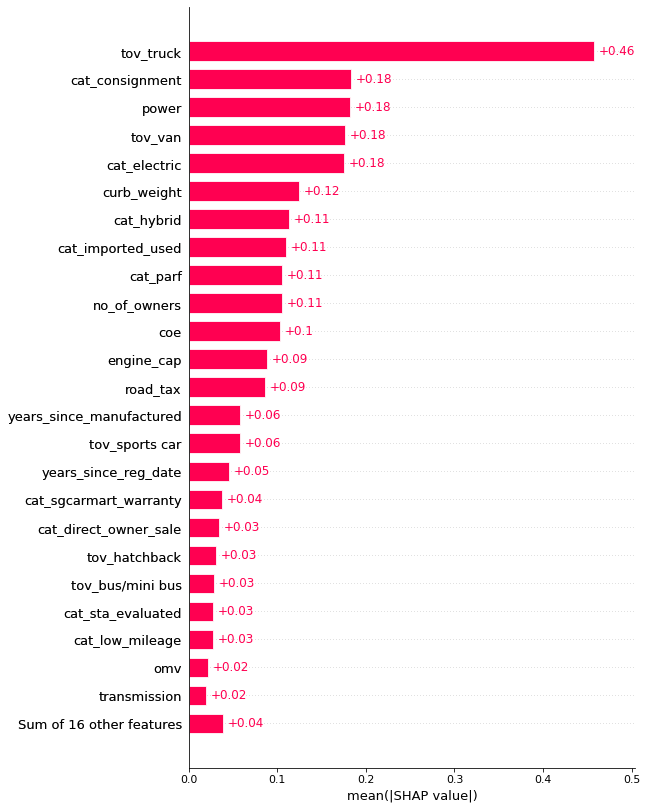

In [78]:
shap.plots.bar(shap_values, max_display=25)

As seen above,

- For the entire dataset, having a `tov_truck` value(i.e the given car is a truck) increasing the chance of being sold by `0.46`.
- The features `power`, `tov_van`, `cat_electric`, `cat_consignment` are also important, and having a high value in these fields(for the category fields, this would just be 1 i.e value signifying presence) will increase the chance of the car being sold.

### Waterfall Plot

We will first visualize the features for a random sample:

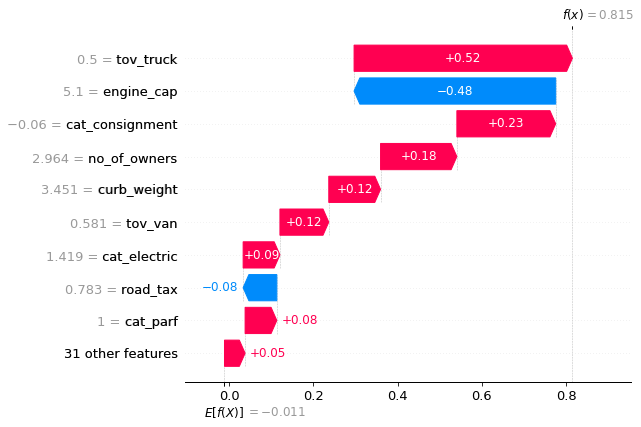

In [72]:
shap.plots.waterfall(shap_values[0])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

For our model, **for the first record in the training set**, we observe that:

- Given the car is a `truck`, the chance of it being sold goes higher. The same applies for when we have a `cat_consignment`, `van` and a high `engine capacity`.
- For the given car, it's `engine_cap` value reduces the chance of the car being sold.

We can visualize the effect of all features for a specific record as shown below:

In [73]:
shap.initjs()
shap.plots.force(shap_values[0])

The above plot shows that:

- The chance of the car being sold is 81%.
- The increase in value of `engine_cap` and `road_tax` for this given car reduce the chance of the car being sold.
- The presentence value of `tov_truck`, `cat_consignment`, and decrease in the `no_of_owners` for this given car increase the chance of the car being sold.

### Force plot

We can also try to visualize the effect of all features for a sample(or all records) of the dataset.

In [74]:
shap.initjs()
shap.plots.force(shap_values.sample(100, random_state=42))

Clicking on the interactive plot above shows the record for which the given feature effects are shown. 

### Dominating Features

We know the the feature `tov_truck` and `cat_consignment` are the two most dominating features for the given model. Here we can also assess the individual impact of these features.

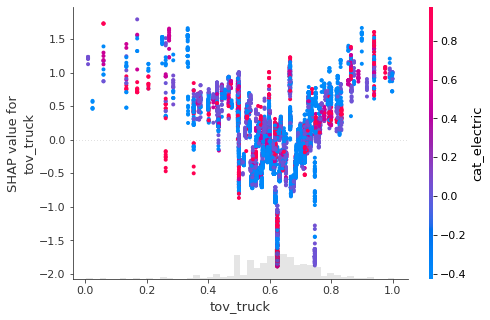

In [75]:
shap.plots.scatter(shap_values[:,"tov_truck"], color=shap_values)

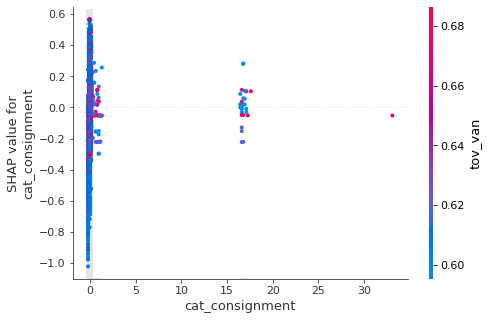

In [76]:
shap.plots.scatter(shap_values[:,"cat_consignment"], color=shap_values)

As noted above, if a car is a truck or a van, the chance of it getting sold is higher, which is also confirmed by the plots shown above.

**NOTE**: The scale of the plots has been normalized as part of the preprocessing. 